In [ ]:
# Unzipping and loading the dataset
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='CT-scan.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('CT-scan.zip')
f.keys()
!unzip 'CT-scan.zip'

Archive:  CT-scan.zip
  inflating: Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/test/adenocarcinoma/000114.png  
  inflating: Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/test/adenocarcinoma/000115.png  
  inflating: Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/test/adenocarcinoma/000116 (9).png  
  inflating: Data/test/adenocarcinoma/000117 (4).png  
  inflating: Data/test/adenocarcinoma/000117 (8).png  
  inflating: Data/test/adenocarcinoma/000117.png  
  inflating: Data/test/adenocarcinoma/000118 (5).png  


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# STEP 1: Install required packages
!pip install tensorflow tqdm --quiet

# STEP 2: Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image, ImageDraw
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# STEP 3: Define paths
input_root = '/content/Data/train'     # The image dataset path
output_root = '/content/CT-scan'    # The Output folder for segmentation masks
os.makedirs(output_root, exist_ok=True)

# STEP 4: Preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB').resize((128, 128))
    image_array = np.array(image) / 255.0
    return np.expand_dims(image_array, axis=0), image.size

# STEP 5: Dummy segmentation model (replace this with real model later)
def dummy_segmentation_model(image_tensor):
    # Simple green channel threshold for demo purposes
    mask = (image_tensor[0][:, :, 1] > 0.5).astype(np.uint8) * 255
    return mask

# STEP 6: Iterate over all class folders
for class_name in os.listdir(input_root):
    class_input_path = os.path.join(input_root, class_name)

    # Skip non-directories like .DS_Store
    if not os.path.isdir(class_input_path):
        continue

    class_output_path = os.path.join(output_root, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    # STEP 7: Process each image
    for img_name in tqdm(os.listdir(class_input_path), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_input_path, img_name)

        # Skip non-image files
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        try:
            img_tensor, original_size = preprocess_image(img_path)

            # Dummy segmentation
            mask = dummy_segmentation_model(img_tensor)

            # Resize mask back to original image size and save
            mask_image = Image.fromarray(mask).resize(original_size)
            mask_image.save(os.path.join(class_output_path, img_name))

        except Exception as e:
            print(f"❌ Failed to process {img_path}: {e}")


Processing large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 100%|██████████| 115/115 [00:00<00:00, 120.80it/s]
Processing normal: 100%|██████████| 148/148 [00:01<00:00, 86.68it/s]
Processing adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 100%|██████████| 195/195 [00:01<00:00, 170.23it/s]
Processing squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 100%|██████████| 155/155 [00:00<00:00, 172.35it/s]


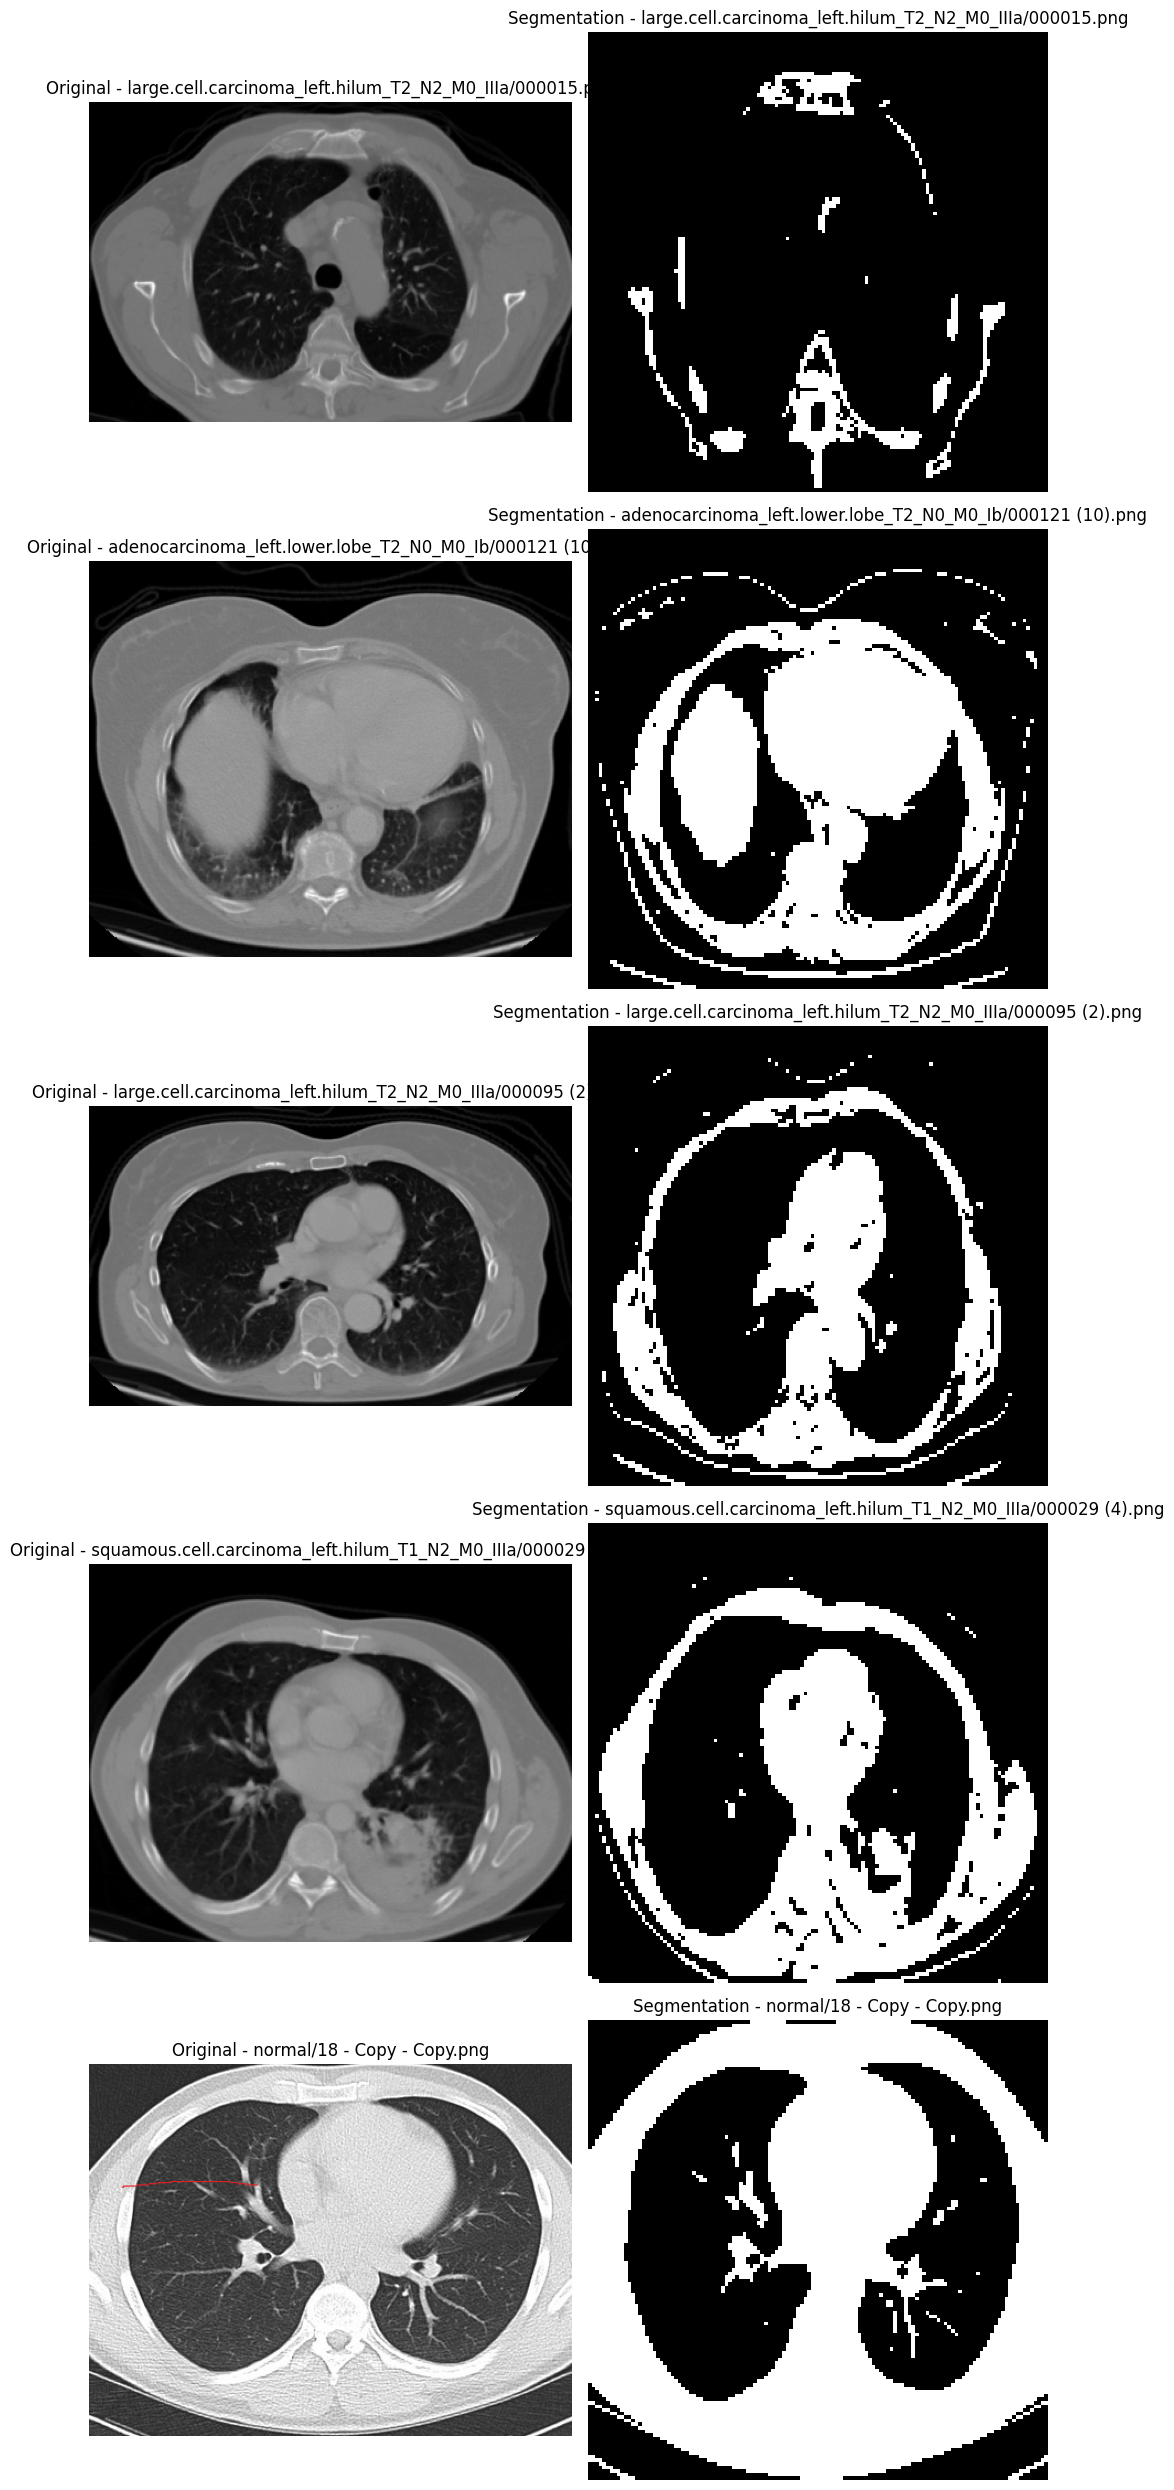

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Paths
original_path = '/content/Data/train'
segmented_path = '/content/CT-scan'

# Number of samples to show
num_samples = 5

# Collect valid (class, image) pairs
samples = []
for class_name in os.listdir(original_path):
    class_orig = os.path.join(original_path, class_name)
    class_seg = os.path.join(segmented_path, class_name)

    if not os.path.isdir(class_orig) or not os.path.isdir(class_seg):
        continue

    images = [f for f in os.listdir(class_orig) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img in images:
        if os.path.exists(os.path.join(class_seg, img)):
            samples.append((class_name, img))

# Randomly select samples
selected_samples = random.sample(samples, min(num_samples, len(samples)))

# Plotting
fig, axes = plt.subplots(len(selected_samples), 2, figsize=(10, 5 * len(selected_samples)))

for i, (cls, img_name) in enumerate(selected_samples):
    orig_img = Image.open(os.path.join(original_path, cls, img_name))
    seg_img = Image.open(os.path.join(segmented_path, cls, img_name))

    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original - {cls}/{img_name}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(seg_img, cmap='gray')
    axes[i, 1].set_title(f"Segmentation - {cls}/{img_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Importing important libraries
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Defining the dataset paths
dataset_path = '/content/CT-scan'

In [ ]:
# Image size and parameters
image_size = 224
input_shape = (image_size, image_size, 3)
batch_size = 32
num_classes = len(os.listdir(dataset_path))  # auto-detect number of classes

In [ ]:

# Creating train and validation generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 491 images belonging to 4 classes.
Found 122 images belonging to 4 classes.


In [ ]:
# Building the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compiling the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model
history = model.fit(
    train_generator,
    epochs=7,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.3331 - loss: 1.6546 - val_accuracy: 0.6393 - val_loss: 1.0721
Epoch 2/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.5671 - loss: 1.0452 - val_accuracy: 0.7295 - val_loss: 0.7698
Epoch 3/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8116 - loss: 0.5887 - val_accuracy: 0.6721 - val_loss: 0.9375
Epoch 4/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8860 - loss: 0.3745 - val_accuracy: 0.7541 - val_loss: 0.7533
Epoch 5/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9450 - loss: 0.1760 - val_accuracy: 0.7541 - val_loss: 0.8489
Epoch 6/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9750 - loss: 0.1048 - val_accuracy: 0.7623 - val_loss: 0.7386
Epoch 7/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9832 - loss: 0.0461 - val_accuracy: 0.7705 - val_loss: 1.1791


In [ ]:
# Evaluating the model
loss, acc = model.evaluate(val_generator)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 732ms/step - accuracy: 0.7759 - loss: 1.1896

✅ Validation Accuracy: 77.05%


In [ ]:
# Classification report
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = preds.argmax(axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 911ms/step

Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.76      0.82      0.79        39
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       1.00      0.48      0.65        23
                                          normal       1.00      0.93      0.96        29
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.57      0.77      0.66        31

                                        accuracy                           0.77       122
                                       macro avg       0.83      0.75      0.76       122
                                    weighted avg       0.81      0.77      0.77       122



In [ ]:

# Saving the model
model.save('/content/ct_scan_model.h5')
print("✅ Model saved as ct_scan_model.h5")


✅ Model saved as ct_scan_model.h5


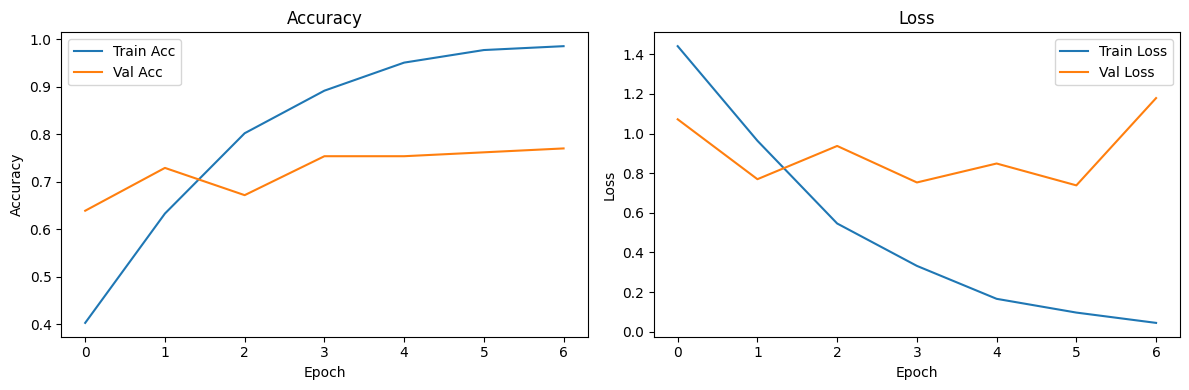

In [ ]:
# Plotting accuracy/loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
